In [19]:
import pandas as pd

# Upload dataset manually in Google Colab, then load it
file_path = "/content/drive/MyDrive/Resume_Parser/dataset/AI_Resume_Screening (1).csv"  # Change path if needed
df = pd.read_csv(file_path)

# Display first few rows
df.head()



,Resume_ID,Name,Skills,Experience (Years),Education,Certifications,Job Role,Recruiter Decision,Salary Expectation ($),Projects Count,AI Score (0-100)
0,1,Ashley Ali,"TensorFlow, NLP, Pytorch",10,B.Sc,NaN,AI Researcher,Hire,104895,8,100
1,2,Wesley Roman,"Deep Learning, Machine Learning, Python, SQL",10,MBA,Google ML,Data Scientist,Hire,113002,1,100
2,3,Corey Sanchez,"Ethical Hacking, Cybersecurity, Linux",1,MBA,Deep Learning Specialization,Cybersecurity Analyst,Hire,71766,7,70
3,4,Elizabeth Carney,"Python, Pytorch, TensorFlow",7,B.Tech,AWS Certified,AI Researcher,Hire,46848,0,95
4,5,Julie Hill,"SQL, React, Java",4,PhD,NaN,Software Engineer,Hire,87441,9,100


In [20]:
# Drop AI Score and Name columns since we'll predict AI Score
df_cleaned = df.drop(columns=["AI Score (0-100)", "Name", "Resume_ID", "Recruiter Decision"])

# Display updated dataset
df_cleaned.head()


,Skills,Experience (Years),Education,Certifications,Job Role,Salary Expectation ($),Projects Count
0,"TensorFlow, NLP, Pytorch",10,B.Sc,NaN,AI Researcher,104895,8
1,"Deep Learning, Machine Learning, Python, SQL",10,MBA,Google ML,Data Scientist,113002,1
2,"Ethical Hacking, Cybersecurity, Linux",1,MBA,Deep Learning Specialization,Cybersecurity Analyst,71766,7
3,"Python, Pytorch, TensorFlow",7,B.Tech,AWS Certified,AI Researcher,46848,0
4,"SQL, React, Java",4,PhD,NaN,Software Engineer,87441,9


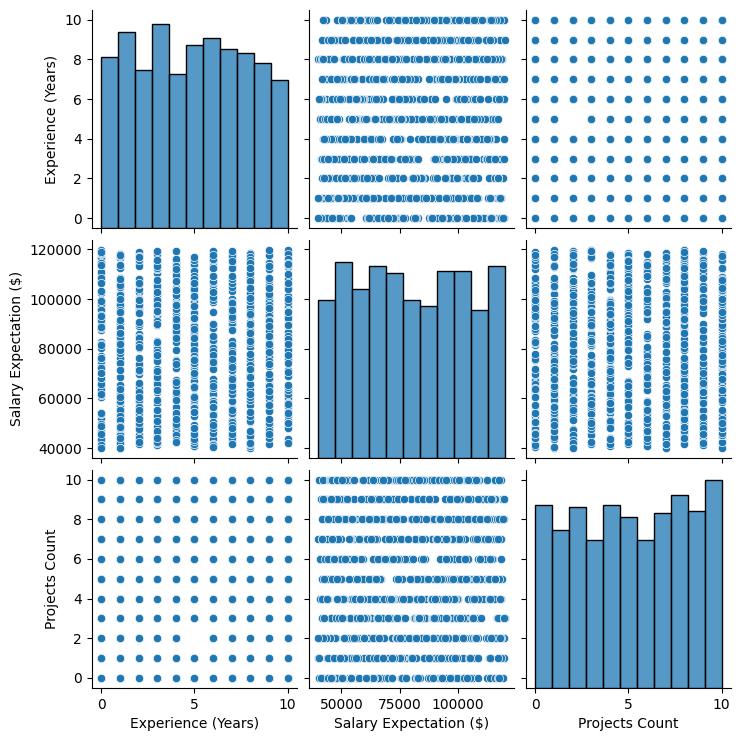

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting only numerical columns for visualization
numeric_cols = ["Experience (Years)", "Salary Expectation ($)", "Projects Count"]

# Pairplot with only numeric columns
sns.pairplot(df_cleaned[numeric_cols], diag_kind="hist")
plt.show()


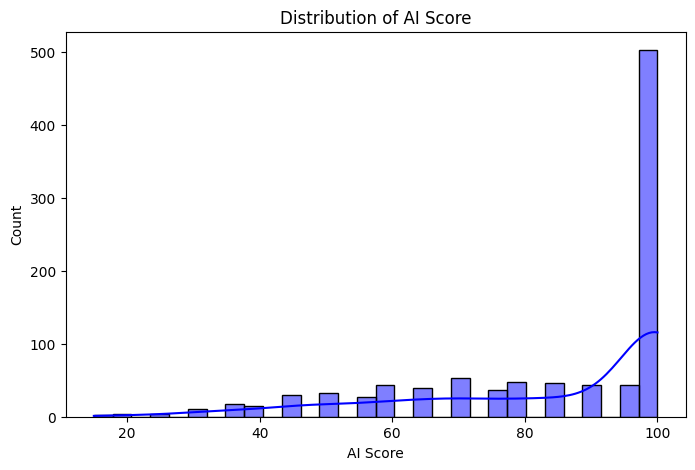

In [22]:
# Distribution plot for AI Score
plt.figure(figsize=(8, 5))
sns.histplot(df["AI Score (0-100)"], bins=30, kde=True, color="blue")
plt.title("Distribution of AI Score")
plt.xlabel("AI Score")
plt.ylabel("Count")
plt.show()


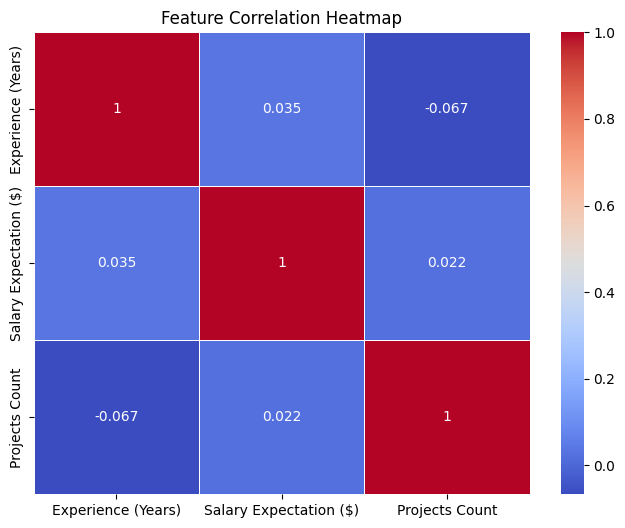

In [23]:
# Heatmap for correlation
plt.figure(figsize=(8, 6))
# Select only numerical features for correlation calculation
numerical_df = df_cleaned.select_dtypes(include=['number'])
sns.heatmap(numerical_df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [24]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
import spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [25]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Function to preprocess text (tokenization, lemmatization, stopwords removal)
def preprocess_text(text):
    if pd.isnull(text):
        return ""  # Handle NaN values
    doc = nlp(text.lower())  # Convert to lowercase and process with spaCy
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]  # Lemmatization & stopword removal
    return " ".join(tokens)

# Apply preprocessing to text columns
text_columns = ["Skills", "Education", "Certifications"]
for col in text_columns:
    df_cleaned[col] = df_cleaned[col].apply(preprocess_text)

# Display processed data
df_cleaned.head()

,Skills,Experience (Years),Education,Certifications,Job Role,Salary Expectation ($),Projects Count
0,tensorflow nlp pytorch,10,,,AI Researcher,104895,8
1,deep learning machine learning python sql,10,mba,google ml,Data Scientist,113002,1
2,ethical hacking cybersecurity linux,1,mba,deep learning specialization,Cybersecurity Analyst,71766,7
3,python pytorch tensorflow,7,,aw certify,AI Researcher,46848,0
4,sql react java,4,phd,,Software Engineer,87441,9


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply TF-IDF to convert text into numerical format
vectorizer = TfidfVectorizer(max_features=500)
skills_tfidf = vectorizer.fit_transform(df_cleaned["Skills"]).toarray()
education_tfidf = vectorizer.fit_transform(df_cleaned["Education"]).toarray()
certifications_tfidf = vectorizer.fit_transform(df_cleaned["Certifications"]).toarray()


In [27]:
import numpy as np

# Convert text data into numerical format
X_text = np.hstack((skills_tfidf, education_tfidf, certifications_tfidf))

# Get numerical columns
X_numeric = df_cleaned[["Experience (Years)", "Salary Expectation ($)", "Projects Count"]].values

# Combine all features
X = np.hstack((X_numeric, X_text))
y = df["AI Score (0-100)"]  # Target variable


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")


Mean Absolute Error: 2.8209999999999997
R2 Score: 0.9619462134311783


In [29]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best Params: {grid_search.best_params_}")

# Train final model with best parameters
best_model = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_model.fit(X_train, y_train)

# Evaluate
y_pred_best = best_model.predict(X_test)
r2_best = r2_score(y_test, y_pred_best)
print(f"Optimized R2 Score: {r2_best}")
# Convert R² score to percentage
r2_best_percent = r2_best * 100
print(f"Optimized R2 Score: {r2_best_percent:.2f}%")



Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Optimized R2 Score: 0.9619462134311783
Optimized R2 Score: 96.19%


In [30]:
import pickle

# Save model & vectorizer
with open("ResumeScreener.pkl", "wb") as f:
    pickle.dump({"model": model, "vectorizer": vectorizer}, f)
